In [ ]:
# ! pip install transformers
# # ! pip install tensorflow==2.13.0

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# import torch
from transformers import BertTokenizer #, BertForSequenceClassification, DistilBertForSequenceClassification, DistilBertTokenizer
from sklearn.model_selection import train_test_split
# from torch.utils.data import Dataset, DataLoader
# import itertools
from tensorflow.nn import softmax
import re
from sklearn.preprocessing import LabelEncoder
import os
import pandas as pd
# import ast
# from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score,f1_score,accuracy_score #pip install -U scikit-learn
# import matplotlib.pyplot as plt
# import seaborn as sns
np.random.seed(42)



In [ ]:

# Dynamically allocate GPU memory
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices),physical_devices)
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Set the TF_GPU_ALLOCATOR environment variable
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'



Num GPUs: 1 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
physical_devices,tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.15.0')

In [ ]:
# dataset_url = "../data_generator/initial_dataset_additonal_api_balanced_normal.csv"
# dataset_url = "dataset.csv"
# dataset_url = "/content/drive/MyDrive/Bikram/test_data.csv"
# dataset_url_10000 = "/content/drive/MyDrive/Bikram/latest_class_10000.csv"
dataset_url = "/content/drive/MyDrive/Bikram/train_balanced_normal.csv"
model_url = "/content/drive/MyDrive/Bikram/model_10000_07_14.keras"

In [ ]:
data = []
with open(dataset_url, 'r') as csvfile:
    for line in csvfile:
        if len(line) > 5:
            a, b = line.split('",', 1)
            a, b = a[2:], b[2:-2]
            bs = re.findall(r"'(.*?)'", b, re.DOTALL)
            bs = ", ".join(bs)
            data.append([a,bs])
# data = data[:10000]
len(data)
# data = data[:100000]

10000

In [ ]:
# Separate code from actions
code = [item[0] for item in data]
actions = [item[1] for item in data]

In [ ]:
# Create a DataFrame from the deserialized data
df = pd.DataFrame(list(zip(code, actions)), columns=['code', 'actions'])
df.head(10)

,code,actions
0,"""result = 0\nfor name22 in names:\n\tfor age1 ...","join(), reduce()"
1,"""outcome = []\nfor num24 in list1:\n\tresult9....","union(), sortBy()"
2,"""resultant = []\nfor obj8 in objects:\n\tfor o...","join(), filter(), map(), reduce()"
3,"""result = 0\nfor city5 in cities:\n\tfor popul...","join(), reduce()"
4,"""result22 = []\nfor entity13 in entities:\n\tf...","join(), filter(), map(), count()"
5,"""outcome = []\nfor X in xs:\n\tif X > 0:\n\t\t...","filter(), map(), reduce()"
6,"""result = []\nfor val7 in data:\n\tresult.appe...",map()
7,"""result = []\nfor val8 in vals:\n\tresult.appe...",map()
8,"""result = len(students)",count()
9,"""result17 = []\nfor textbook in texts:\n\tif '...","filter(), map(), join()"


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('actions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

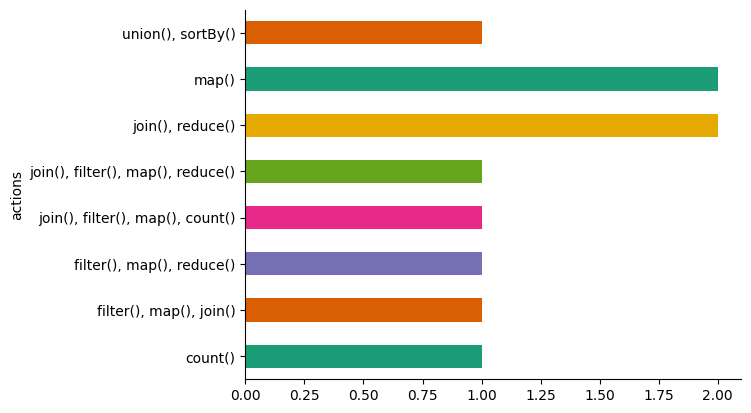

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('actions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
unique,count = np.unique(df['actions'],return_counts = True)


In [ ]:
len(set(df['actions']))

109

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the code
input_ids = [tokenizer.encode(c, add_special_tokens=True) for c in df['code']]

# Pad sequences to ensure uniform length
code_padded = pad_sequences(input_ids, maxlen=256, dtype="long", value=0, truncating="post", padding="post")
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder to the actions
label_encoder.fit(df['actions'])

# Transform the actions to integers
actions_encoded = label_encoder.transform(df['actions'])
action_one_hot = to_categorical(actions_encoded, num_classes = len(set(df['actions'])))

In [ ]:
code_train, code_val, actions_train, actions_val = train_test_split(code_padded, action_one_hot, test_size=0.3, random_state=42,shuffle=True)
# code_val, code_test, actions_val, actions_test = train_test_split(code_test, actions_test, test_size=0.5, random_state=42,shuffle=True)

In [ ]:
print(f"Training code size: {len(code_train)}")
print(f"Validation code size: {len(code_val)}")
# print(f"Test code size: {len(actions_test)}")

Training code size: 7000
Validation code size: 3000


In [ ]:
predicted_label = label_encoder.inverse_transform([actions_encoded[200]])
# Get the integer-encoded label from the one-hot encoded label
integer_encoded_label = np.argmax(action_one_hot[200])
# Decode the integer-encoded label to the original class label
predicted_label_onehot = label_encoder.inverse_transform([integer_encoded_label])

In [ ]:
# Checking if the encoding is right. Check for sample number 200
print(f"The original data sample 200 is: {data[200]}")
print(f"The data after splitting into code and sample is: {code[200],actions[200]}")
print(f"The code sample after decoding the tokenizer is {tokenizer.decode(code_padded[200])}")
print(f"The label after decoding the label encoding is: {predicted_label_onehot}")
print(f"The label after decoding the label one hot encoding is: {predicted_label_onehot}")


The original data sample 200 is: ['"event = []\\nfor entity8 in entities:\\n\\tfor entity14 in entities1:\\n\\t\\tif entity8.isActive and entity14.isActive:\\n\\t\\t\\tresult.append(entity8.property)\\nresult = len(event)', 'join(), filter(), map(), count()']
The data after splitting into code and sample is: ('"event = []\\nfor entity8 in entities:\\n\\tfor entity14 in entities1:\\n\\t\\tif entity8.isActive and entity14.isActive:\\n\\t\\t\\tresult.append(entity8.property)\\nresult = len(event)', 'join(), filter(), map(), count()')
The code sample after decoding the tokenizer is [CLS] " event = [ ] \ nfor entity8 in entities : \ n \ tfor entity14 in entities1 : \ n \ t \ tif entity8. isactive and entity14. isactive : \ n \ t \ t \ tresult. append ( entity8. property ) \ nresult = len ( event ) [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [ ]:
assert predicted_label_onehot == actions[200]

In [ ]:
print(f"The current unique class is: {len(set(df['actions']))}")
assert len(set(df['actions'])) == len(set(actions_encoded))

The current unique class is: 109


In [ ]:
# from keras.src.metrics.confusion_metrics import TruePositives
# Define the BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = len(set(df['actions'])))
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(mlb.classes_))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'Categorical_accuracy')
# metric_f1 = tf.keras.metrics.F1Score(name = 'f1_score')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric_accuracy])
# Train the model


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# import tensorflow as tf

class MetricsLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        # Initialize lists to store metrics
        self.train_loss = []
        self.train_accuracy = []
        self.train_f1 = []
        self.val_loss = []
        self.val_accuracy = []
        self.val_f1 = []

    def on_batch_end(self, batch, logs=None):
        # Append training metrics after each batch
        self.train_loss.append(logs['loss'])
        self.train_accuracy.append(logs['Categorical_accuracy'])
        # self.train_f1.append(logs['f1_score'])

    def on_epoch_end(self, epoch, logs=None):
        # Append validation metrics after each epoch
        self.val_loss.append(logs['val_loss'])
        self.val_accuracy.append(logs['val_Categorical_accuracy'])
        # self.val_f1.append(logs['val_f1_score'])
# Instantiate the custom callback
metrics_logger = MetricsLogger()

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [ ]:

# Train the model


# Train the model with the custom callback
model.fit(code_train, actions_train, epochs= 5, batch_size = 64, validation_data=(code_val, actions_val), callbacks=[metrics_logger])

#save the TFBERT model


Epoch 1/5
110/110 [==============================] - 94s 852ms/step - loss: 0.1430 - Categorical_accuracy: 0.9916 - val_loss: 0.1239 - val_Categorical_accuracy: 0.9910
Epoch 2/5
110/110 [==============================] - 94s 851ms/step - loss: 0.1167 - Categorical_accuracy: 0.9937 - val_loss: 0.0998 - val_Categorical_accuracy: 0.9930
Epoch 3/5
110/110 [==============================] - 94s 851ms/step - loss: 0.0964 - Categorical_accuracy: 0.9947 - val_loss: 0.1680 - val_Categorical_accuracy: 0.9777
Epoch 4/5
110/110 [==============================] - 93s 851ms/step - loss: 0.0930 - Categorical_accuracy: 0.9934 - val_loss: 0.0715 - val_Categorical_accuracy: 0.9963
Epoch 5/5
110/110 [==============================] - 93s 851ms/step - loss: 0.0662 - Categorical_accuracy: 0.9977 - val_loss: 0.0608 - val_Categorical_accuracy: 0.9947


In [ ]:
# # Train the model
# # Instantiate the custom callback
# metrics_logger = MetricsLogger()

# # Train the model with the custom callback
# model.fit(code_train, actions_train, epochs= 5, batch_size = 32, validation_data=(code_val, actions_val), callbacks=[metrics_logger])

# # model.fit(code_train, actions_train, epochs=2, batch_size = 64, validation_data=(code_val, actions_val))


# Temp start

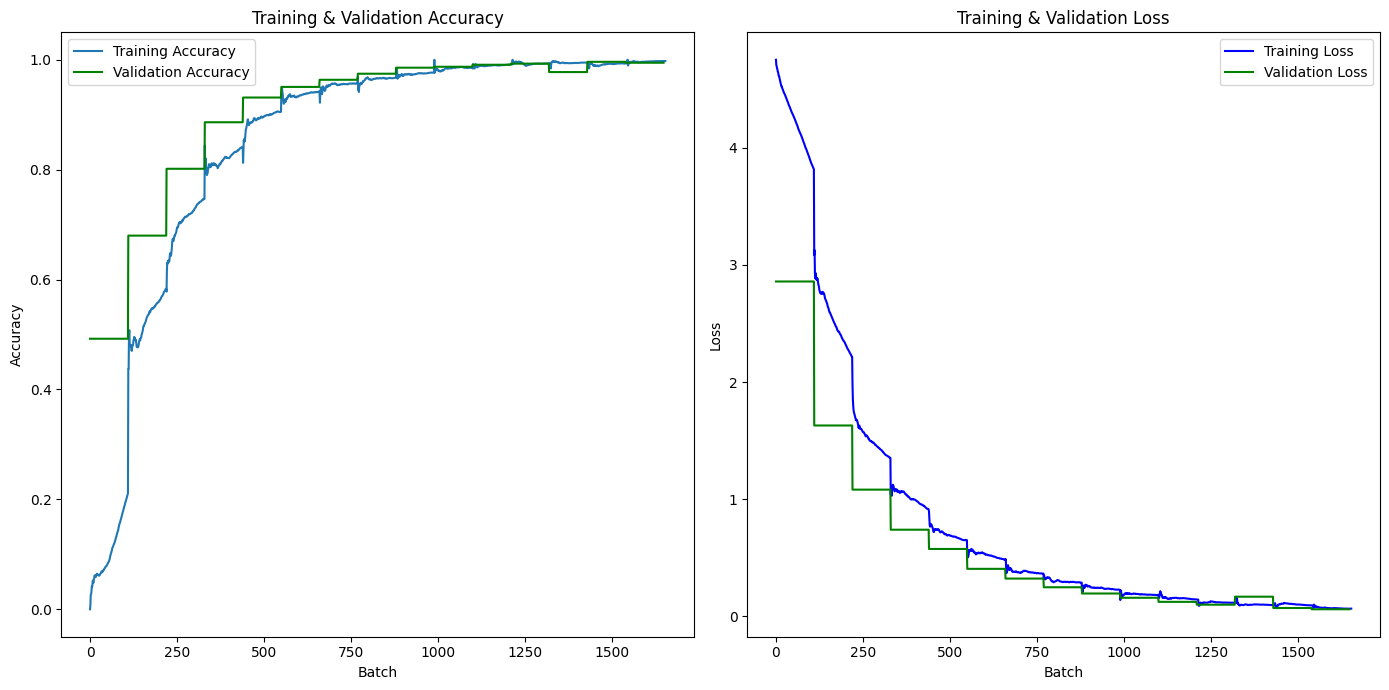

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the number of batches per epoch
batches_per_epoch = len(metrics_logger.train_loss) // len(metrics_logger.val_loss)

# Repeat the validation metrics for each batch within an epoch
val_accuracy_repeated = np.repeat(metrics_logger.val_accuracy, batches_per_epoch)
val_loss_repeated = np.repeat(metrics_logger.val_loss, batches_per_epoch)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot Training & Validation Accuracy
axes[0].plot(metrics_logger.train_accuracy, '-', label="Training Accuracy")
axes[0].plot(val_accuracy_repeated, 'g-', label="Validation Accuracy")
axes[0].set_title("Training & Validation Accuracy")
axes[0].set_xlabel("Batch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

# Plot Training & Validation Loss
axes[1].plot(metrics_logger.train_loss, 'b-', label="Training Loss")
axes[1].plot(val_loss_repeated, 'g-', label="Validation Loss")
axes[1].set_title("Training & Validation Loss")
axes[1].set_xlabel("Batch")
axes[1].set_ylabel("Loss")
axes[1].legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Bikram/acc_loss_figures_10000_31_01_24.png",dpi = 400)
plt.show()


In [ ]:
# Evaluate the model on the test set
model.evaluate(code_val, actions_val)

94/94 [==============================] - 13s 139ms/step - loss: 0.0608 - Categorical_accuracy: 0.9947


[0.06080060452222824, 0.9946666955947876]

In [ ]:
test_data_url = "/content/drive/MyDrive/Bikram/test.csv"
testdata = []
with open(test_data_url, 'r') as csvfile:
    for line in csvfile:
        if len(line) > 5:
            a, b = line.split('",', 1)
            a, b = a[2:], b[2:-2]
            bs = re.findall(r"'(.*?)'", b, re.DOTALL)
            bs = ", ".join(bs)
            testdata.append([a,bs])
# data = data[:10000]
len(testdata)
# data = data[:100000]

100

In [ ]:
# Separate code from actions
code = [item[0] for item in testdata]
actions = [item[1] for item in testdata]
df = pd.DataFrame(list(zip(code, actions)), columns=['code', 'actions'])

# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the code
input_ids = [tokenizer.encode(c, add_special_tokens=True) for c in df['code']]

# Pad sequences to ensure uniform length
code_test = pad_sequences(input_ids, maxlen=256, dtype="long", value=0, truncating="post", padding="post")


# # Transform the actions to integers
# actions_encoded = label_encoder.transform(df['actions'])
# actions_test = to_categorical(actions_encoded, num_classes = len(set(df['actions'])))



In [ ]:

# Let's assume that you have some test data in variables code_test and actions_test

# Number of samples to display
num_samples = 10

# Select a subset of the test data
code_samples = code_test[:num_samples]

# Make predictions using the model
logits = model.predict(code_samples)

# Extract the logits from the TFSequenceClassifierOutput object
logits_values = logits.logits

# Convert logits to probabilities
probs = softmax(logits_values)

# Find the class with the maximum probability
predicted_classes = np.argmax(probs, axis=1)

# Decode the predicted class indices back to labels
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Decode the real labels from integer to original

# Print the real and predicted labels
for i in range(num_samples):
    print(f"Sample {i+1}")
    code_snap = code_samples[i]
    decode_code_snap = tokenizer.decode(code_snap)
    # replace ["SEP"], ["PAD"] and ["CLS"] tokens with empty string
    decode_code_snap = decode_code_snap.replace("[SEP]", "").replace("[PAD]", "").replace("[CLS]", "")
    decode_code_snap = decode_code_snap.replace("\ n", "\n\t")
    decode_code_snap = decode_code_snap.replace("\ t", "\t")
    print(f"Code: {decode_code_snap}")
    print(f"Real label: {df['actions'][i]}")
    print(f"Predicted label: {[predicted_labels[i]]}\n")
    print("--------------------------------------------------")
    # break

1/1 [==============================] - 0s 88ms/step
Sample 1
Code:  esult = 0 
	for city in cities : 
	 	for population in populations : 
	 	 	if city! = population : 
	 	 	 	result + = len ( city ) + population 
	result = result                                                                                                                                                                                                        
Real label: filter(), join(), reduce()
Predicted label: ['filter(), join(), reduce()']

--------------------------------------------------
Sample 2
Code:  esult = [ ] 
	for item in items : 
	 	if item. isactive : 
	 	 	result. append ( item. property ) 
	result = sum ( result )                                                                                                                                                                                                                 
Real label: filter(), map(), sum()
Predicted label: ['filter(), map(), sum()']

--